In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [ ]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [ ]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [ ]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [ ]:
def build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=8, strides=1, padding='valid', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=8*(2**(i+1)), strides=1, padding='valid'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [ ]:
for i in range(1, 9):
    model = build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15996, 8)          32        
_________________________________________________________________
activation (Activation)      (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5332, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 42656)             0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_10 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_10 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_11 (B (None, 5328, 16)          64        
_________________________________________________________________
activation_11 (Activation)   (None, 5328, 16)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 15996, 8)          48        
_________________________________________________________________
batch_normalization_v1_28 (B (None, 15996, 8)          32        
_________________________________________________________________
activation_28 (Activation)   (None, 15996, 8)          0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5332, 8)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 5328, 16)          656       
_________________________________________________________________
batch_normalization_v1_29 (B (None, 5328, 16)          64        
_________________________________________________________________
activation_29 (Activation)   (None, 5328, 16)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.8060 - acc: 0.1843
Epoch 00001: val_loss improved from inf to 2.32255, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_1_conv_checkpoint/001-2.3225.hdf5
36805/36805 [==============================] - 11s 286us/sample - loss: 2.8063 - acc: 0.1844 - val_loss: 2.3225 - val_acc: 0.2639
Epoch 2/500
36672/36805 [============================>.] - ETA: 0s - loss: 2.2411 - acc: 0.3018
Epoch 00002: val_loss improved from 2.32255 to 2.22095, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_1_conv_checkpoint/002-2.2210.hdf5
36805/36805 [==============================] - 8s 227us/sample - loss: 2.2411 - acc: 0.3018 - val_loss: 2.2210 - val_acc: 0.3168
Epoch 3/500
36672/36805 [============================>.] - ETA: 0s - loss: 1.9925 - acc: 0.3735
Epoch 00003: val_loss improved from 2.22095 to 2.18127

Epoch 29/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9686 - acc: 0.6859
Epoch 00029: val_loss did not improve from 2.18127
36805/36805 [==============================] - 8s 227us/sample - loss: 0.9685 - acc: 0.6858 - val_loss: 2.6140 - val_acc: 0.3354
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.9644 - acc: 0.6895
Epoch 00030: val_loss did not improve from 2.18127
36805/36805 [==============================] - 8s 227us/sample - loss: 0.9642 - acc: 0.6894 - val_loss: 2.5368 - val_acc: 0.3550
Epoch 31/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9541 - acc: 0.6914
Epoch 00031: val_loss did not improve from 2.18127
36805/36805 [==============================] - 8s 228us/sample - loss: 0.9543 - acc: 0.6914 - val_loss: 2.5265 - val_acc: 0.3569
Epoch 32/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.9454 - acc: 0.6916
Epoch 00032: val_loss did not improve from 2.18127
36805/36805 [========

Epoch 59/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8150 - acc: 0.7365
Epoch 00059: val_loss did not improve from 2.18127
36805/36805 [==============================] - 9s 237us/sample - loss: 0.8157 - acc: 0.7362 - val_loss: 2.8362 - val_acc: 0.3578
Epoch 60/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8091 - acc: 0.7362
Epoch 00060: val_loss did not improve from 2.18127
36805/36805 [==============================] - 9s 236us/sample - loss: 0.8095 - acc: 0.7359 - val_loss: 2.8281 - val_acc: 0.3685
Epoch 61/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8123 - acc: 0.7369
Epoch 00061: val_loss did not improve from 2.18127
36805/36805 [==============================] - 9s 235us/sample - loss: 0.8120 - acc: 0.7369 - val_loss: 2.8297 - val_acc: 0.3629
Epoch 62/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.8110 - acc: 0.7369
Epoch 00062: val_loss did not improve from 2.18127
36805/36805 [========

Epoch 89/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7446 - acc: 0.7596
Epoch 00089: val_loss did not improve from 2.18127
36805/36805 [==============================] - 8s 226us/sample - loss: 0.7444 - acc: 0.7596 - val_loss: 2.9824 - val_acc: 0.3629
Epoch 90/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7393 - acc: 0.7575
Epoch 00090: val_loss did not improve from 2.18127
36805/36805 [==============================] - 8s 226us/sample - loss: 0.7403 - acc: 0.7571 - val_loss: 2.9719 - val_acc: 0.3580
Epoch 91/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7354 - acc: 0.7606
Epoch 00091: val_loss did not improve from 2.18127
36805/36805 [==============================] - 8s 227us/sample - loss: 0.7350 - acc: 0.7607 - val_loss: 2.9954 - val_acc: 0.3569
Epoch 92/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.7318 - acc: 0.7620
Epoch 00092: val_loss did not improve from 2.18127
36805/36805 [========

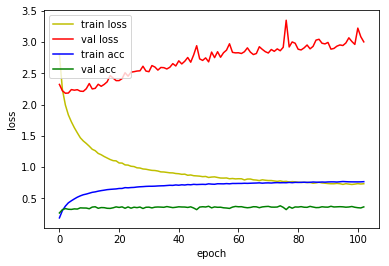

4815/4815 [==============================] - 1s 199us/sample - loss: 2.2417 - acc: 0.3151
Loss: 2.241665267251115 Accuracy: 0.3150571

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.8560 - acc: 0.2086
Epoch 00001: val_loss improved from inf to 2.21674, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_2_conv_checkpoint/001-2.2167.hdf5
36805/36805 [==============================] - 14s 373us/sample - loss: 2.8546 - acc: 0.2088 - val_loss: 2.2167 - val_acc: 0.2944
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.0723 - acc: 0.3571
Epoch 00002: val_loss improved from 2.21674 to 1.79946, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_2_conv_checkpoint/002-1.7995.hdf5
36805/36805 [==============================] - 12s 323us/sample - loss: 2.0718 - acc: 0.3573 - val_loss: 1.7995 - val_acc: 0.4386
Epoch 3/500
36736/36805 [============================>.] - ETA

Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.7721
Epoch 00027: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 320us/sample - loss: 0.6908 - acc: 0.7721 - val_loss: 1.6715 - val_acc: 0.5441
Epoch 28/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6824 - acc: 0.7728
Epoch 00028: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 321us/sample - loss: 0.6829 - acc: 0.7725 - val_loss: 1.5618 - val_acc: 0.5653
Epoch 29/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6718 - acc: 0.7759
Epoch 00029: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 318us/sample - loss: 0.6717 - acc: 0.7758 - val_loss: 1.6246 - val_acc: 0.5500
Epoch 30/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.6566 - acc: 0.7824
Epoch 00030: val_loss did not improve from 1.48399
36805/36805 [=====

Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4617 - acc: 0.8444
Epoch 00057: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 315us/sample - loss: 0.4620 - acc: 0.8443 - val_loss: 1.8681 - val_acc: 0.5434
Epoch 58/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4692 - acc: 0.8450
Epoch 00058: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 318us/sample - loss: 0.4690 - acc: 0.8449 - val_loss: 1.7675 - val_acc: 0.5558
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4618 - acc: 0.8455
Epoch 00059: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 317us/sample - loss: 0.4621 - acc: 0.8456 - val_loss: 1.6331 - val_acc: 0.5763
Epoch 60/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.4530 - acc: 0.8484
Epoch 00060: val_loss did not improve from 1.48399
36805/36805 [=====

Epoch 87/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3754 - acc: 0.8746
Epoch 00087: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 319us/sample - loss: 0.3756 - acc: 0.8746 - val_loss: 2.2873 - val_acc: 0.4838
Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3629 - acc: 0.8791
Epoch 00088: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 319us/sample - loss: 0.3627 - acc: 0.8793 - val_loss: 1.7090 - val_acc: 0.5970
Epoch 89/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3592 - acc: 0.8805
Epoch 00089: val_loss did not improve from 1.48399
36805/36805 [==============================] - 12s 315us/sample - loss: 0.3593 - acc: 0.8806 - val_loss: 1.7816 - val_acc: 0.5723
Epoch 90/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3577 - acc: 0.8829
Epoch 00090: val_loss did not improve from 1.48399
36805/36805 [=====

Epoch 117/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3044 - acc: 0.9006
Epoch 00117: val_loss did not improve from 1.48399
36805/36805 [==============================] - 11s 311us/sample - loss: 0.3044 - acc: 0.9006 - val_loss: 1.8481 - val_acc: 0.5775

1D_CNN_only_conv_conv_5_DO_BN_2_conv Model


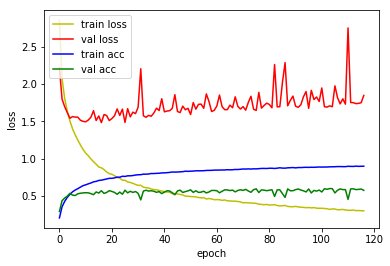

4815/4815 [==============================] - 1s 227us/sample - loss: 1.5744 - acc: 0.5394
Loss: 1.5744021488746256 Accuracy: 0.5393562

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4629 - acc: 0.2697
Epoch 00001: val_loss improved from inf to 1.83709, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_3_conv_checkpoint/001-1.8371.hdf5
36805/36805 [==============================] - 17s 458us/sample - loss: 2.4628 - acc: 0.2698 - val_loss: 1.8371 - val_acc: 0.3976
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7392 - acc: 0.4434
Epoch 00002: val_loss improved from 1.83709 to 1.45393, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_3_conv_checkpoint/002-1.4539.hdf5
36805/36805 [==============================] - 14s 370us/sample - loss: 1.7393 - acc: 0.4434 - val_loss: 1.4539 - val_acc: 0.5518
Epoch 3/500
36672/36805 [============================>.] - ET

Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5801 - acc: 0.8117
Epoch 00026: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 365us/sample - loss: 0.5803 - acc: 0.8117 - val_loss: 1.2087 - val_acc: 0.6527
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5622 - acc: 0.8142
Epoch 00027: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 364us/sample - loss: 0.5620 - acc: 0.8142 - val_loss: 1.3361 - val_acc: 0.6150
Epoch 28/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5625 - acc: 0.8141
Epoch 00028: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 365us/sample - loss: 0.5619 - acc: 0.8143 - val_loss: 1.0628 - val_acc: 0.6942
Epoch 29/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.5479 - acc: 0.8221
Epoch 00029: val_loss did not improve from 1.02877
36805/36805 [=====

36736/36805 [============================>.] - ETA: 0s - loss: 0.3821 - acc: 0.8728
Epoch 00055: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 362us/sample - loss: 0.3820 - acc: 0.8728 - val_loss: 1.1251 - val_acc: 0.6981
Epoch 56/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3785 - acc: 0.8746
Epoch 00056: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 365us/sample - loss: 0.3786 - acc: 0.8745 - val_loss: 1.1355 - val_acc: 0.6995
Epoch 57/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3768 - acc: 0.8763
Epoch 00057: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 366us/sample - loss: 0.3768 - acc: 0.8763 - val_loss: 1.1151 - val_acc: 0.7060
Epoch 58/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.3663 - acc: 0.8793- ETA: 0s - loss: 0.3663 - acc:
Epoch 00058: val_loss did not improve from 1.02877


Epoch 85/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2848 - acc: 0.9060
Epoch 00085: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 363us/sample - loss: 0.2849 - acc: 0.9058 - val_loss: 1.0657 - val_acc: 0.7326
Epoch 86/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2899 - acc: 0.9034
Epoch 00086: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 362us/sample - loss: 0.2896 - acc: 0.9035 - val_loss: 1.1306 - val_acc: 0.7151
Epoch 87/500
36672/36805 [============================>.] - ETA: 0s - loss: 0.2798 - acc: 0.9090
Epoch 00087: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 366us/sample - loss: 0.2799 - acc: 0.9090 - val_loss: 1.1973 - val_acc: 0.6995
Epoch 88/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2801 - acc: 0.9080
Epoch 00088: val_loss did not improve from 1.02877
36805/36805 [=====

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2316 - acc: 0.9229
Epoch 00115: val_loss did not improve from 1.02877
36805/36805 [==============================] - 13s 365us/sample - loss: 0.2315 - acc: 0.9229 - val_loss: 1.0990 - val_acc: 0.7356
Epoch 116/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9236
Epoch 00116: val_loss did not improve from 1.02877
36805/36805 [==============================] - 14s 368us/sample - loss: 0.2328 - acc: 0.9237 - val_loss: 1.2976 - val_acc: 0.6928

1D_CNN_only_conv_conv_5_DO_BN_3_conv Model


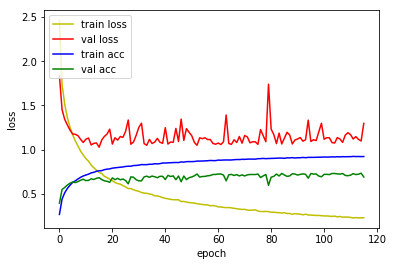

4815/4815 [==============================] - 1s 285us/sample - loss: 1.1190 - acc: 0.6567
Loss: 1.1190139128164092 Accuracy: 0.6566978

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5148 - acc: 0.2413
Epoch 00001: val_loss improved from inf to 1.88865, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_4_conv_checkpoint/001-1.8887.hdf5
36805/36805 [==============================] - 20s 556us/sample - loss: 2.5134 - acc: 0.2415 - val_loss: 1.8887 - val_acc: 0.3955
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7659 - acc: 0.4333
Epoch 00002: val_loss improved from 1.88865 to 1.37810, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_4_conv_checkpoint/002-1.3781.hdf5
36805/36805 [==============================] - 16s 423us/sample - loss: 1.7659 - acc: 0.4333 - val_loss: 1.3781 - val_acc: 0.5642
Epoch 3/500
36736/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.5883 - acc: 0.8160
Epoch 00025: val_loss did not improve from 0.75722
36805/36805 [==============================] - 15s 418us/sample - loss: 0.5883 - acc: 0.8159 - val_loss: 0.8213 - val_acc: 0.7617
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5771 - acc: 0.8203
Epoch 00026: val_loss improved from 0.75722 to 0.75623, saving model to model/checkpoint/1D_CNN_only_conv_conv_5_DO_BN_4_conv_checkpoint/026-0.7562.hdf5
36805/36805 [==============================] - 16s 423us/sample - loss: 0.5771 - acc: 0.8204 - val_loss: 0.7562 - val_acc: 0.7843
Epoch 27/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5628 - acc: 0.8231
Epoch 00027: val_loss did not improve from 0.75623
36805/36805 [==============================] - 15s 421us/sample - loss: 0.5630 - acc: 0.8230 - val_loss: 0.8771 - val_acc: 0.7405
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0

In [ ]:
for i in range(1, 9):
    base = '1D_CNN_only_conv_conv_5_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_only_conv_conv_5_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=100)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [ ]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_only_conv_conv_5_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, accuracy, loss])+'\n')